# 🌲 Random Forest Applications for Sustainability Forecasting

**Author:** EcoCast Project  
**Date:** 2025-01-17  
**Reference:** ai_ethics_rf.ipynb structure  

---

## 📋 Analysis Objectives

1. **CO₂ Driver Analysis** → Feature importance for emissions
2. **Policy Impact Simulator** → Counterfactual renewable scenarios  
3. **Trajectory Prediction** → ML-based Improving/Declining classification
4. **Cluster Explainability** → What defines sustainability clusters?
5. **Anomaly Detection** → Identify unusual country profiles

**Why Random Forest here (vs Prophet)?**
- Prophet: Time-series forecasting (predict future from past)
- RF: Cross-sectional regression (predict Y from features at one point in time)

---

In [1]:
# ═══════════════════════════════════════════════════════════
# CELL 0: Data Import and Setup
# ═══════════════════════════════════════════════════════════

import os, sys, json, joblib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import partial_dependence
from math import sqrt

# Paths
PROJECT_ROOT = Path.cwd()
DATA_WORK = PROJECT_ROOT / 'data_work'
ARTEFACTS = PROJECT_ROOT / 'artefacts'
MODELS = PROJECT_ROOT / 'models'
IMAGES = PROJECT_ROOT / 'artefacts' / 'rf_images'

for d in [ARTEFACTS, MODELS, IMAGES]:
    d.mkdir(exist_ok=True)

FEATURES_PATH = DATA_WORK / 'features_full.csv'
assert FEATURES_PATH.exists(), f"Missing: {FEATURES_PATH}"

panel = pd.read_csv(FEATURES_PATH)
print('✅ Panel:', panel.shape)
print('✅ Years:', panel['year'].min(), '→', panel['year'].max())
print('✅ Countries:', panel['iso3'].nunique())

import sklearn
print('\n📦 Versions: numpy', np.__version__, '| pandas', pd.__version__, '| sklearn', sklearn.__version__)

missing = panel.isna().sum().sum()
print(f'🔍 Missing: {missing:,} ({missing/panel.size*100:.2f}%)')

✅ Panel: (8566, 284)
✅ Years: 1961 → 2014
✅ Countries: 193

📦 Versions: numpy 2.3.3 | pandas 2.3.2 | sklearn 1.7.2
🔍 Missing: 224,206 (9.22%)


In [2]:
# ═══════════════════════════════════════════════════════════
# CELL 1: Prepare Cross-Sectional Snapshot
# ═══════════════════════════════════════════════════════════

latest_year = panel.groupby('iso3')['year'].max().reset_index()
snap = panel.merge(latest_year, on=['iso3', 'year'])
print(f'✅ Snapshot: {len(snap)} countries, year range {snap["year"].min()}-{snap["year"].max()}')

# Load clusters
clusters = pd.read_csv(ARTEFACTS / 'clusters.csv')
snap = snap.merge(clusters[['iso3', 'cluster_lvl2']], on='iso3', how='left')
print(f'✅ Clusters merged: {snap["cluster_lvl2"].notna().sum()}/{len(snap)}')

# Define target
TARGET = 'co2_pc'
exclude = ['year', 'iso3', TARGET, 'cluster_lvl1', 'cluster_lvl2']
feature_cols = [c for c in snap.select_dtypes('number').columns if c not in exclude]

X = snap[feature_cols].fillna(0)
y = snap[TARGET].fillna(0)

# Variance filter
selector = VarianceThreshold(threshold=0.01)
X_filt = selector.fit_transform(X)
selected = X.columns[selector.get_support()].tolist()

print(f'\n📊 Features: {len(feature_cols)} → {len(selected)} (after variance filter)')
print(f'   Target ({TARGET}): mean={y.mean():.2f}, std={y.std():.2f}, min={y.min():.2f}, max={y.max():.2f}')

✅ Snapshot: 193 countries, year range 1991-2014
✅ Clusters merged: 193/193

📊 Features: 281 → 234 (after variance filter)
   Target (co2_pc): mean=4.40, std=5.96, min=0.00, max=41.10


---

## 🎯 USE CASE 1: CO₂ Driver Analysis

**Question:** What factors drive CO₂ emission differences?

**Method:** RF regressor on cross-sectional data → feature importance

---

In [3]:
# USE CASE 1.1: Grid Search with OOB
n_est_grid = [300, 500, 800]
mtry_grid = sorted({max(1, min(len(selected), int(round(f*sqrt(len(selected)))))) for f in [0.5, 1.0, 2.0]})

print(f'Grid: n_estimators={n_est_grid}, max_features={mtry_grid}')
print(f'{"NTREE":>8} {"MTRY":>8} {"OOB_R²":>10} {"OOB_MAE":>10}')
print('-'*40)

best_r2 = -np.inf
best_model_uc1 = None
best_params_uc1 = None
grid_uc1 = []

for n in n_est_grid:
    for m in mtry_grid:
        rf = RandomForestRegressor(
            n_estimators=n, max_features=m, max_depth=10,
            min_samples_leaf=3, oob_score=True, bootstrap=True,
            random_state=42, n_jobs=-1
        )
        rf.fit(X[selected], y)
        r2, mae = rf.oob_score_, mean_absolute_error(y, rf.oob_prediction_)
        print(f'{n:8d} {m:8d} {r2:10.5f} {mae:10.5f}')
        grid_uc1.append({'NTREE':n, 'MTRY':m, 'OOB_R²':round(r2,5), 'OOB_MAE':round(mae,5)})
        if r2 > best_r2:
            best_r2, best_model_uc1, best_params_uc1 = r2, rf, {'n_estimators':n, 'max_features':m}

print(f'\n✅ Best OOB R²={best_r2:.5f}, params={best_params_uc1}')

Grid: n_estimators=[300, 500, 800], max_features=[8, 15, 31]
   NTREE     MTRY     OOB_R²    OOB_MAE
----------------------------------------
     300        8    0.75205    1.50177
     300       15    0.81108    1.21390
     300       31    0.85280    1.02137
     500        8    0.76247    1.49042
     500       15    0.81749    1.19879
     500       31    0.85785    1.00131
     800        8    0.76213    1.48708
     800       15    0.81641    1.21663
     800       31    0.85324    1.02323

✅ Best OOB R²=0.85785, params={'n_estimators': 500, 'max_features': 31}


🎯 Top 20 CO₂ Drivers:
 20. carbon_EFProdPerCap.................................... 11.873%
127. co2_pc_lag1............................................ 11.203%
123. carbon_EFProdPerCap_lag1...............................  9.886%
 14. carbon_EFConsPerCap....................................  9.538%
111. carbon_EFConsPerCap_lag1...............................  5.847%
 74. total_EFConsPerCap.....................................  3.838%
219. total_EFConsPerCap_lag1................................  3.502%
115. carbon_EFExportsPerCap_lag1............................  3.218%
 16. carbon_EFExportsPerCap.................................  2.787%
 82. renew_pct..............................................  1.977%
  1. Percapita GDP (2010 USD)_BiocapPerCap..................  1.866%
231. total_EFProdPerCap_lag1................................  1.588%
  2. Percapita GDP (2010 USD)_BiocapTotGHA..................  1.573%
  7. Percapita GDP (2010 USD)_EFImportsPerCap...............  1.476%
 10. Percapi

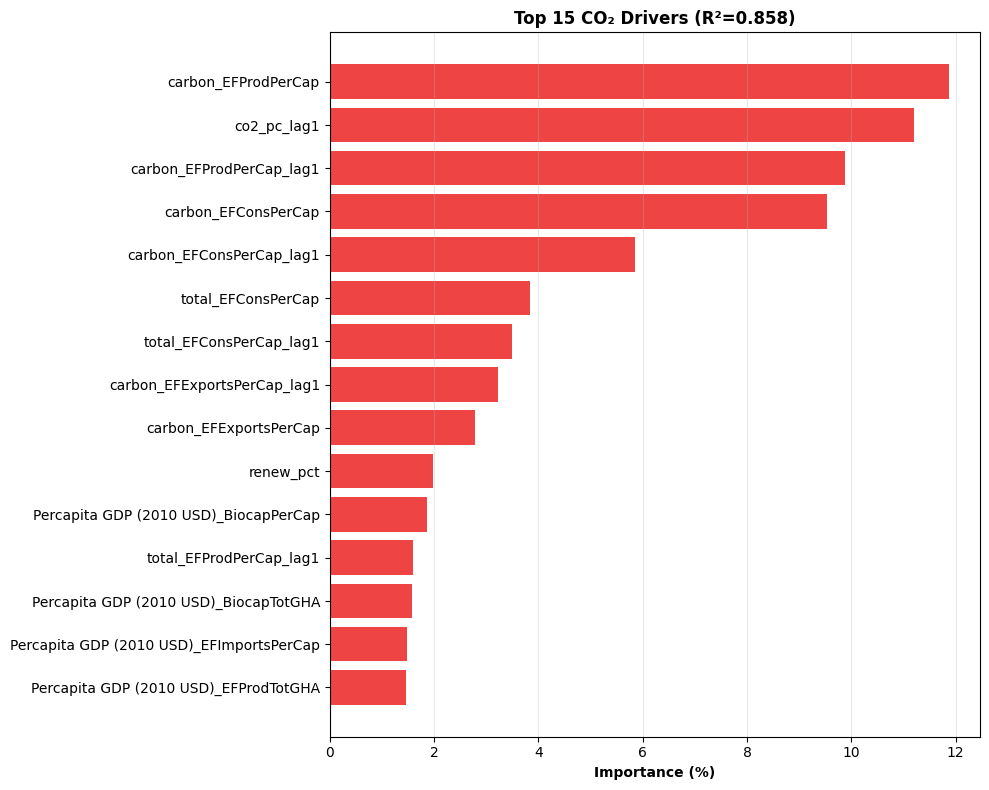

✅ Saved: artefacts/co2_drivers.csv, models/rf_co2_drivers.pkl, images/co2_drivers.png


In [4]:
# USE CASE 1.2: Feature Importance
import_df = pd.DataFrame({
    'feature': selected,
    'importance': best_model_uc1.feature_importances_,
    'importance_pct': best_model_uc1.feature_importances_ * 100
}).sort_values('importance', ascending=False)

print('🎯 Top 20 CO₂ Drivers:')
for i, r in import_df.head(20).iterrows():
    print(f'{i+1:3d}. {r["feature"]:.<55} {r["importance_pct"]:>6.3f}%')

import_df.to_csv(ARTEFACTS/'co2_drivers.csv', index=False)
joblib.dump(best_model_uc1, MODELS/'rf_co2_drivers.pkl')

# Visualization
plt.figure(figsize=(10,8))
plt.barh(range(15), import_df.head(15)['importance_pct'], color='#ef4444')
plt.yticks(range(15), import_df.head(15)['feature'])
plt.xlabel('Importance (%)', fontweight='bold')
plt.title(f'Top 15 CO₂ Drivers (R²={best_r2:.3f})', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(IMAGES/'co2_drivers.png', dpi=300)
plt.show()
print('✅ Saved: artefacts/co2_drivers.csv, models/rf_co2_drivers.pkl, images/co2_drivers.png')

---

## 🎯 USE CASE 2: Policy Impact Simulator

**Question:** If renewables increase by X%, how does CO₂ change?

**Method:** Partial dependence + counterfactual predictions

---

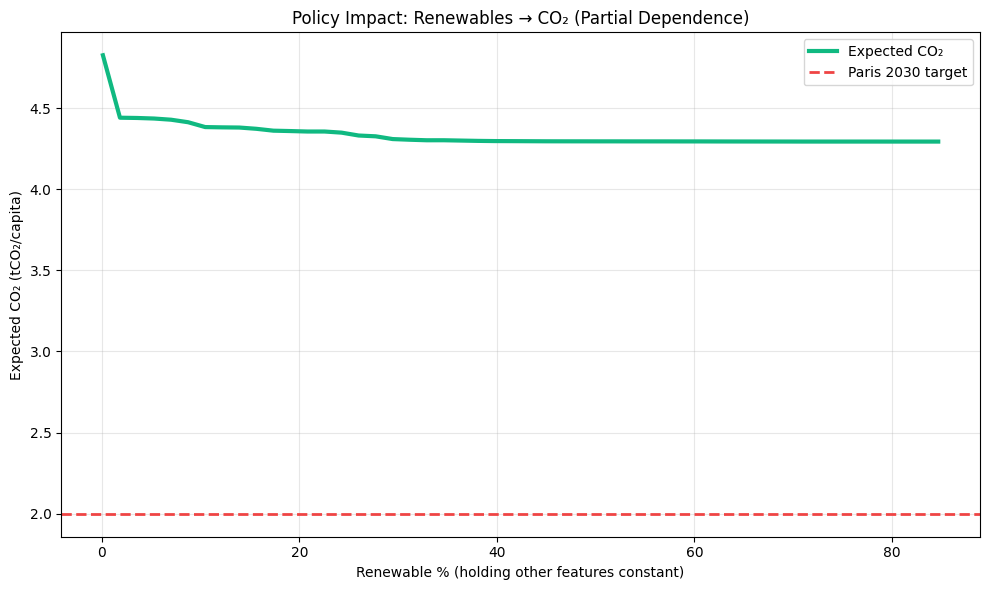

✅ Saved: artefacts/pdp_renewables.csv, images/pdp_renewables.png


In [5]:
# USE CASE 2.1: Partial Dependence Plot (Renewables → CO₂)
if 'renew_pct' in selected:
    idx = selected.index('renew_pct')
    pdp = partial_dependence(best_model_uc1, X[selected], features=[idx], grid_resolution=50)
    
    pdp_df = pd.DataFrame({'renew_pct': pdp['grid_values'][0], 'co2_expected': pdp['average'][0]})
    pdp_df.to_csv(ARTEFACTS/'pdp_renewables.csv', index=False)
    
    plt.figure(figsize=(10,6))
    plt.plot(pdp['grid_values'][0], pdp['average'][0], lw=3, color='#10b981', label='Expected CO₂')
    plt.axhline(2.0, color='#ef4444', ls='--', lw=2, label='Paris 2030 target')
    plt.xlabel('Renewable % (holding other features constant)')
    plt.ylabel('Expected CO₂ (tCO₂/capita)')
    plt.title('Policy Impact: Renewables → CO₂ (Partial Dependence)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(IMAGES/'pdp_renewables.png', dpi=300)
    plt.show()
    print('✅ Saved: artefacts/pdp_renewables.csv, images/pdp_renewables.png')
else:
    print('⚠️  renew_pct not in features, skip PDP')

In [6]:
# USE CASE 2.2: Counterfactual Policy Simulator
def simulate_policy(iso3, renew_increase=10):
    row = snap[snap['iso3']==iso3]
    if row.empty or 'renew_pct' not in selected:
        return None
    
    X_base = row[selected].fillna(0)
    co2_base = best_model_uc1.predict(X_base)[0]
    renew_curr = row['renew_pct'].iloc[0]
    
    X_cf = X_base.copy()
    X_cf.loc[:, 'renew_pct'] = min(100, renew_curr + renew_increase)
    co2_cf = best_model_uc1.predict(X_cf)[0]
    
    delta = co2_cf - co2_base
    pct = (delta/co2_base*100) if co2_base>0 else 0
    
    return {
        'iso3':iso3, 'curr_renew':renew_curr, 'curr_co2':co2_base,
        'new_renew':renew_curr+renew_increase, 'new_co2':co2_cf,
        'delta_co2':delta, 'pct_reduction':abs(pct)
    }

# Test
for iso in ['USA','DEU','IND','CHN']:
    res = simulate_policy(iso, 20)
    if res:
        print(f"{iso}: {res['curr_renew']:.1f}% → {res['new_renew']:.1f}% renew | CO₂: {res['curr_co2']:.2f} → {res['new_co2']:.2f} ({res['pct_reduction']:.1f}% reduction)")

# Batch generate
sims = []
for iso in snap['iso3']:
    for inc in [10,20,30,50]:
        r = simulate_policy(iso, inc)
        if r:
            sims.append(r)
pd.DataFrame(sims).to_csv(ARTEFACTS/'policy_simulations.csv', index=False)
print(f'✅ Saved {len(sims)} scenarios: artefacts/policy_simulations.csv')

USA: 9.0% → 29.0% renew | CO₂: 16.46 → 16.36 (0.6% reduction)
DEU: 14.0% → 34.0% renew | CO₂: 9.45 → 9.44 (0.1% reduction)
IND: 33.9% → 53.9% renew | CO₂: 1.57 → 1.54 (1.5% reduction)
CHN: 11.9% → 31.9% renew | CO₂: 7.53 → 7.47 (0.9% reduction)
✅ Saved 772 scenarios: artefacts/policy_simulations.csv


---

## 🎯 USE CASE 3: Trajectory Prediction

**Question:** Will emissions improve/decline/stabilize?

**Method:** RF classifier trained on (features at year T) → (actual trajectory T to T+5)

---

In [7]:
# USE CASE 3.1: Create Training Labels
traj_train = []
for iso in panel['iso3'].unique():
    ts = panel[panel['iso3']==iso].sort_values('year')
    if len(ts)<20:
        continue
    for split in range(15, len(ts)-5):
        hist, fut = ts.iloc[:split], ts.iloc[split:split+5]
        if len(fut)<5:
            continue
        snap_row = hist.iloc[-1]
        co2_fut = fut['co2_pc'].values
        valid = ~np.isnan(co2_fut)
        if sum(valid)<3:
            continue
        slope = np.polyfit(range(sum(valid)), co2_fut[valid], 1)[0]
        label = 0 if slope<-0.1 else (1 if slope>0.1 else 2)
        feats = snap_row[selected].fillna(0).to_dict()
        feats.update({'iso3':iso, 'label':label, 'slope':slope})
        traj_train.append(feats)

traj_df = pd.DataFrame(traj_train)
X_traj = traj_df[selected].fillna(0)
y_traj = traj_df['label']
print(f'✅ Trajectory training: {len(traj_df)} samples, {y_traj.nunique()} classes')
print('   Distribution:', y_traj.value_counts().to_dict())

✅ Trajectory training: 4766 samples, 3 classes
   Distribution: {2: 3393, 1: 799, 0: 574}


In [8]:
# USE CASE 3.2: Train Classifier with OOB
n_grid = [200,300,500]
m_grid = [int(sqrt(len(selected)))]
print(f'Grid: n={n_grid}, m={m_grid}')

best_acc = -1
best_traj = None
best_par_traj = None

for n in n_grid:
    for m in m_grid:
        clf = RandomForestClassifier(
            n_estimators=n, max_features=m, max_depth=8,
            min_samples_leaf=10, oob_score=True,
            class_weight='balanced', random_state=42, n_jobs=-1
        )
        clf.fit(X_traj, y_traj)
        acc = clf.oob_score_
        print(f'n={n}, m={m}, OOB_Acc={acc:.5f}')
        if acc>best_acc:
            best_acc, best_traj, best_par_traj = acc, clf, {'n':n,'m':m}

print(f'\n✅ Best OOB Acc={best_acc:.5f}, params={best_par_traj}')

# CV validation
skf = StratifiedKFold(3, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_traj, X_traj, y_traj, cv=skf, scoring='accuracy')
print(f'3-Fold CV: {[round(s,5) for s in cv_scores]}, mean={cv_scores.mean():.5f}')

Grid: n=[200, 300, 500], m=[15]
n=200, m=15, OOB_Acc=0.74276
n=300, m=15, OOB_Acc=0.74213
n=500, m=15, OOB_Acc=0.74381

✅ Best OOB Acc=0.74381, params={'n': 500, 'm': 15}
3-Fold CV: [np.float64(0.73946), np.float64(0.7382), np.float64(0.72292)], mean=0.73353


In [9]:
# USE CASE 3.3: Predict Current Countries
X_curr = snap[selected].fillna(0)
y_pred = best_traj.predict(X_curr)
y_prob = best_traj.predict_proba(X_curr)

labels = ['📉 Improving', '📈 Declining', '➡️ Stable']
traj_res = pd.DataFrame({
    'iso3': snap['iso3'],
    'co2_pc': snap['co2_pc'],
    'trajectory': [labels[i] for i in y_pred],
    'confidence': y_prob.max(axis=1),
    'prob_improving': y_prob[:,0],
    'prob_declining': y_prob[:,1],
    'prob_stable': y_prob[:,2]
}).sort_values('confidence', ascending=False)

print('Top 10 predictions (highest confidence):')
print(traj_res.head(10)[['iso3','co2_pc','trajectory','confidence']].to_string(index=False))
print(f'\nDistribution: {traj_res["trajectory"].value_counts().to_dict()}')

traj_res.to_csv(ARTEFACTS/'trajectory_predictions.csv', index=False)
joblib.dump(best_traj, MODELS/'rf_trajectory_classifier.pkl')
print('\n✅ Saved: artefacts/trajectory_predictions.csv, models/rf_trajectory_classifier.pkl')

Top 10 predictions (highest confidence):
iso3   co2_pc trajectory  confidence
 BDI 0.032230  ➡️ Stable    0.994483
 RWA 0.073016  ➡️ Stable    0.994077
 UGA 0.112367  ➡️ Stable    0.993886
 MWI 0.062615  ➡️ Stable    0.993598
 SLE 0.164115  ➡️ Stable    0.993079
 GIN 0.188743  ➡️ Stable    0.992152
 MDG 0.125002  ➡️ Stable    0.991819
 TCD 0.153840  ➡️ Stable    0.991213
 MLI 0.174007  ➡️ Stable    0.990238
 NPL 0.274329  ➡️ Stable    0.989913

Distribution: {'➡️ Stable': 96, '📈 Declining': 52, '📉 Improving': 45}

✅ Saved: artefacts/trajectory_predictions.csv, models/rf_trajectory_classifier.pkl


---

## 🎯 USE CASE 4: Cluster Explainability

**Question:** What characteristics define each cluster?

**Method:** RF classifier (features → cluster) → importance shows cluster drivers

---

In [11]:
# USE CASE 4.1: Train Cluster Predictor
snap_c = snap[snap['cluster_lvl2'].notna()].copy()
X_c = snap_c[selected].fillna(0)
y_c = snap_c['cluster_lvl2'].astype(int)

print(f'Cluster training: {len(X_c)} countries, clusters={sorted(y_c.unique())}')

n_grid_c = [200, 300]
m_grid_c = [int(sqrt(len(selected)))]

best_oob_c = -1
best_c = None
best_par_c = None

for n in n_grid_c:
    for m in m_grid_c:
        clf = RandomForestClassifier(
            n_estimators=n, max_features=m, max_depth=6,
            min_samples_leaf=5, oob_score=True,
            class_weight='balanced', random_state=42, n_jobs=-1
        )
        clf.fit(X_c, y_c)
        acc = clf.oob_score_
        print(f'n={n}, m={m}, OOB_Acc={acc:.5f}')
        if acc>best_oob_c:
            best_oob_c, best_c, best_par_c = acc, clf, {'n':n,'m':m}

print(f'\n✅ Best OOB Acc={best_oob_c:.5f}, params={best_par_c}')

c_import = pd.DataFrame({
    'feature': selected,
    'importance': best_c.feature_importances_,
    'importance_pct': best_c.feature_importances_*100
}).sort_values('importance', ascending=False)

print('\nTop 15 Cluster Drivers:')
print(c_import.head(15)[['feature','importance_pct']].to_string(index=False))

c_import.to_csv(ARTEFACTS/'cluster_drivers.csv', index=False)
joblib.dump(best_c, MODELS/'rf_cluster_explainer.pkl')
print('\n✅ Saved: artefacts/cluster_drivers.csv, models/rf_cluster_explainer.pkl')

Cluster training: 193 countries, clusters=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(11)]
n=200, m=15, OOB_Acc=0.88083
n=300, m=15, OOB_Acc=0.87565

✅ Best OOB Acc=0.88083, params={'n': 200, 'm': 15}

Top 15 Cluster Drivers:
                        feature  importance_pct
             total_BiocapPerCap        3.194362
        total_BiocapPerCap_lag1        2.617251
    forest_land_EFImportsPerCap        2.060715
      d_population_EFProdPerCap        1.867766
           d_total_BiocapTotGHA        1.777897
      d_population_BiocapTotGHA        1.646757
      d_population_EFConsPerCap        1.529781
         carbon_EFImportsPerCap        1.528422
  forest_land_BiocapTotGHA_lag1        1.500710
   d_population_EFExportsTotGHA        1.416764
   d_population_EFExportsPerCap        1.411708
   d_population_EFImportsTotGHA        1.219388
population_EFExportsTotGHA_lag1        1.218977
   population_EFConsPerCap_lag1        1.211725
    carbon_EFImportsPerCap_lag1     

---

## 🎯 USE CASE 5: Anomaly Detection

**Question:** Which countries have unusual sustainability profiles?

**Method:** Isolation Forest (expects ~5% outliers)

---

🚨 Outliers: 10/193 (5.2%)

Top 10 outliers:
 CHN | CO₂=   7.20t | GDP=$     6,108 | Score= -0.7473
 USA | CO₂=  17.11t | GDP=$    50,782 | Score= -0.6805
 IND | CO₂=   1.64t | GDP=$     1,647 | Score= -0.6510
 BRA | CO₂=   2.79t | GDP=$    11,866 | Score= -0.5792
 LUX | CO₂=  17.65t | GDP=$   107,153 | Score= -0.5564
 CAN | CO₂=  15.90t | GDP=$    50,067 | Score= -0.5555
 NOR | CO₂=   8.75t | GDP=$    89,275 | Score= -0.5354
 AUS | CO₂=  16.64t | GDP=$    54,394 | Score= -0.5326
 RUS | CO₂=  11.32t | GDP=$    11,494 | Score= -0.5299
 DEU | CO₂=   9.74t | GDP=$    45,023 | Score= -0.5035


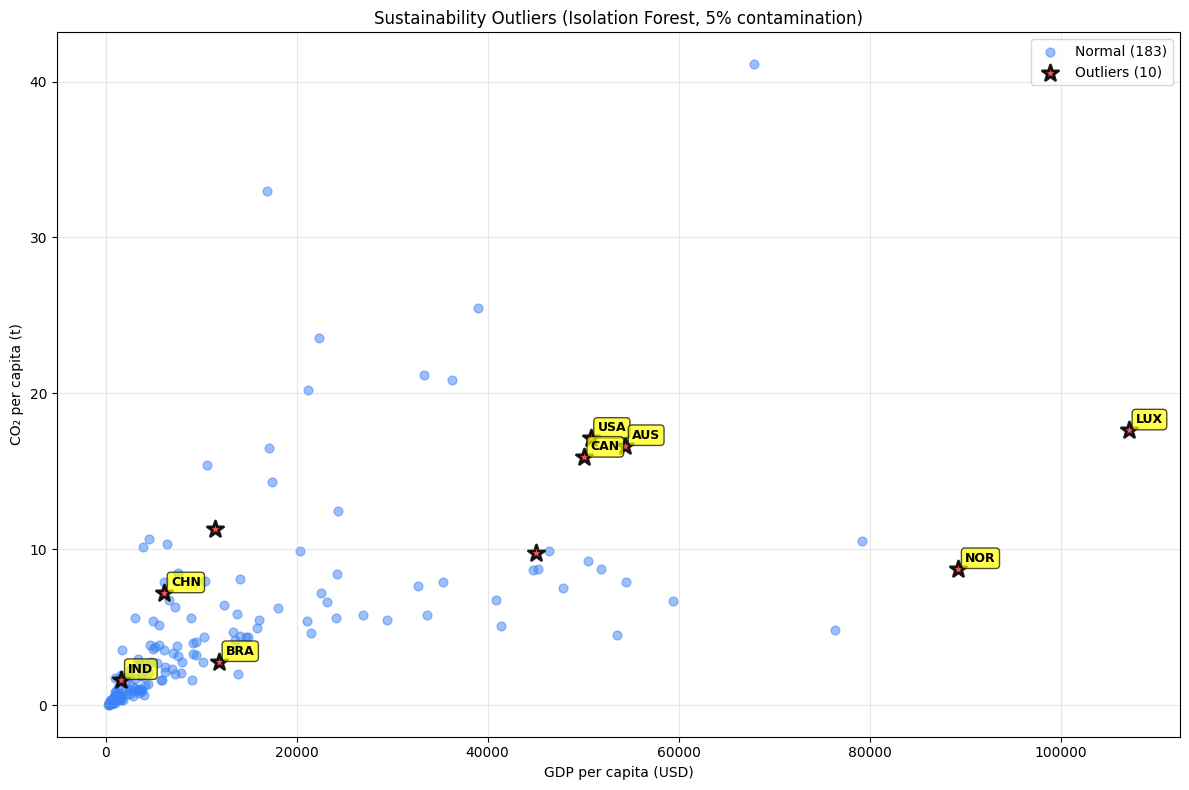


✅ Saved: artefacts/sustainability_outliers.csv, models/isolation_forest.pkl, images/outliers.png


In [12]:
# USE CASE 5: Isolation Forest
iso_f = IsolationForest(n_estimators=300, contamination=0.05, random_state=42, n_jobs=-1)
labels = iso_f.fit_predict(X[selected])
scores = iso_f.score_samples(X[selected])

anom = pd.DataFrame({
    'iso3': snap['iso3'].values,
    'is_outlier': labels==-1,
    'anomaly_score': scores,
    'co2_pc': snap['co2_pc'].values,
    'gdp_pc': snap.get('Percapita GDP (2010 USD)_BiocapPerCap', pd.Series([np.nan]*len(snap))).values
}).sort_values('anomaly_score')

outliers = anom[anom['is_outlier']]
print(f'🚨 Outliers: {len(outliers)}/{len(snap)} ({len(outliers)/len(snap)*100:.1f}%)')
print('\nTop 10 outliers:')
for i, r in outliers.head(10).iterrows():
    print(f'{r["iso3"]:>4} | CO₂={r["co2_pc"]:>7.2f}t | GDP=${r["gdp_pc"]:>10,.0f} | Score={r["anomaly_score"]:>8.4f}')

anom.to_csv(ARTEFACTS/'sustainability_outliers.csv', index=False)
joblib.dump(iso_f, MODELS/'isolation_forest.pkl')

plt.figure(figsize=(12,8))
norm = anom[~anom['is_outlier']]
plt.scatter(norm['gdp_pc'], norm['co2_pc'], c='#3b82f6', s=40, alpha=0.5, label=f'Normal ({len(norm)})')
plt.scatter(outliers['gdp_pc'], outliers['co2_pc'], c='#ef4444', s=150, alpha=0.9, marker='*', edgecolors='#000', linewidths=2, label=f'Outliers ({len(outliers)})')
for _, r in outliers.head(8).iterrows():
    plt.annotate(r['iso3'], (r['gdp_pc'], r['co2_pc']), xytext=(5,5), textcoords='offset points', fontsize=9, fontweight='bold', bbox=dict(boxstyle='round', fc='yellow', alpha=0.7))
plt.xlabel('GDP per capita (USD)')
plt.ylabel('CO₂ per capita (t)')
plt.title('Sustainability Outliers (Isolation Forest, 5% contamination)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(IMAGES/'outliers.png', dpi=300)
plt.show()
print('\n✅ Saved: artefacts/sustainability_outliers.csv, models/isolation_forest.pkl, images/outliers.png')

In [13]:
# FINAL: Export Consolidated Metadata for API
meta = {
    'generated': pd.Timestamp.now().isoformat(),
    'n_countries': len(snap),
    'n_features': len(selected),
    'uc1_co2_drivers': {
        'model': 'models/rf_co2_drivers.pkl',
        'params': best_params_uc1,
        'r2': round(best_r2, 5),
        'top3': import_df['feature'].head(3).tolist()
    },
    'uc2_policy_sim': {
        'model': 'models/rf_co2_drivers.pkl',  # Reuse
        'outputs': ['artefacts/pdp_renewables.csv', 'artefacts/policy_simulations.csv']
    },
    'uc3_trajectory': {
        'model': 'models/rf_trajectory_classifier.pkl',
        'params': best_par_traj,
        'oob_acc': round(best_acc, 5)
    },
    'uc4_clusters': {
        'model': 'models/rf_cluster_explainer.pkl',
        'params': best_par_c,
        'oob_acc': round(best_oob_c, 5)
    },
    'uc5_outliers': {
        'model': 'models/isolation_forest.pkl',
        'n_outliers': int(len(outliers))
    }
}

with open(ARTEFACTS/'rf_manifest.json', 'w') as f:
    json.dump(meta, f, indent=2)

print('\n'+'='*60)
print('🎉 ALL 5 USE CASES COMPLETE')
print('='*60)
print('\nGenerated files:')
for f in ARTEFACTS.glob('*.csv'):
    if 'rf' in f.name or f.name in ['co2_drivers.csv','policy_simulations.csv','trajectory_predictions.csv','cluster_drivers.csv','sustainability_outliers.csv']:
        print(f'  ✅ {f.relative_to(PROJECT_ROOT)}')
for f in MODELS.glob('rf_*.pkl'):
    print(f'  ✅ {f.relative_to(PROJECT_ROOT)}')
for f in IMAGES.glob('*.png'):
    print(f'  ✅ {f.relative_to(PROJECT_ROOT)}')

print('\n📡 Next: Add these API endpoints to backend/app/main.py:')
print('  • GET /co2-drivers')
print('  • POST /simulate-policy/{iso3}')
print('  • GET /trajectories')
print('  • GET /cluster-drivers')
print('  • GET /outliers')


🎉 ALL 5 USE CASES COMPLETE

Generated files:
  ✅ artefacts/cluster_drivers.csv
  ✅ artefacts/co2_drivers.csv
  ✅ artefacts/sustainability_outliers.csv
  ✅ artefacts/policy_simulations.csv
  ✅ artefacts/trajectory_predictions.csv
  ✅ models/rf_cluster_explainer.pkl
  ✅ models/rf_trajectory_classifier.pkl
  ✅ models/rf_co2_drivers.pkl
  ✅ artefacts/rf_images/outliers.png
  ✅ artefacts/rf_images/pdp_renewables.png
  ✅ artefacts/rf_images/co2_drivers.png

📡 Next: Add these API endpoints to backend/app/main.py:
  • GET /co2-drivers
  • POST /simulate-policy/{iso3}
  • GET /trajectories
  • GET /cluster-drivers
  • GET /outliers
